In [3]:
import os
import yaml
import shutil
from tqdm import tqdm
from datetime import datetime

In [4]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

In [5]:
HOME = os.getcwd()

!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10n.pt

In [6]:
from ultralytics import YOLOv10
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

In [7]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
jupyterlab 4.2.3 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.

In [8]:
from roboflow import Roboflow
# dataset from https://universe.roboflow.com/david-glu/cotskaggle

ROBOFLOW_API_KEY = "rWU1eQHaSgCK3DzRY2TP"
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("david-glu").project("cotskaggle")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to COTSKaggle-1 in yolov8:: 100%|██████████| 18870/18870 [00:05<00:00, 3205.08it/s]


In [9]:
!cat COTSKaggle-1/data.yaml

names:
- json
nc: 1
roboflow:
  license: CC BY 4.0
  project: cotskaggle
  url: https://universe.roboflow.com/david-glu/cotskaggle/dataset/1
  version: 1
  workspace: david-glu
test: ../test/images
train: COTSKaggle-1/train/images
val: COTSKaggle-1/valid/images


In [16]:
!mkdir datasets/ 


mkdir: cannot create directory 'datasets/': File exists


In [18]:
!mv {HOME}/COTSKaggle-1 datasets/

mv: cannot stat '/kaggle/working/COTSKaggle-1': No such file or directory


In [22]:
# replace class 'json' to 'starfish' in data.yaml
DATASET_PATH = f'{HOME}/datasets/COTSKaggle-1/'

with open(DATASET_PATH + 'data.yaml', 'r') as f:
    data = yaml.safe_load(f)

data['names'] = ['starfish']
data['train'] = DATASET_PATH + 'train/images'
data['val'] = DATASET_PATH + 'valid/images'
data['test'] = DATASET_PATH +'test/images'

with open(DATASET_PATH + 'data.yaml', 'w') as file:
    yaml.dump(data, file, indent=4)

In [23]:
def label_path_to_bbox(label_path: str, normalized=True) -> list:
    with open(label_path, 'r') as file:
        # Read the content of the file
        file_content = file.read()
        
    detections = file_content.split('\n')
#     print(detections)
    str_boxes = [str_box.split(' ') for str_box in detections]
#     print(str_boxes)
    
    bboxes = []
    
    if normalized == False:
        image_path = label_path.replace('.txt','.jpg').replace( "labels", "images")
        image_width, image_height = Image.open(image_path).size
    
    for str_box in str_boxes:
        str_box_no_class = str_box[1:]
        float_box = [float(value) for value in str_box_no_class]
        
        if normalized == False:
            x_center = float_box[0] * image_width
            y_center = float_box[1] * image_height
            width = float_box[2] * image_width
            height = float_box[3] * image_height
            float_box = [x_center, y_center, width, height]
           
        bboxes.append(float_box)
        
    return bboxes    

In [24]:
def plot_image_with_bboxes(image, bboxes, normalized=True):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    # Display the image
    ax.imshow(image)
    # Get image dimensions
    image_width, image_height = image.size
    # Plot each bounding box
    for bbox in bboxes:
        if normalized == False:
            x_center = bbox[0]
            y_center = bbox[1]
            width = bbox[2]
            height = bbox[3]
        else:   
            x_center = bbox[0] * image_width
            y_center = bbox[1] * image_height
            width = bbox[2] * image_width
            height = bbox[3] * image_height
        
        # Calculate the top-left corner of the rectangle
        top_left_x = x_center - width / 2
        top_left_y = y_center - height / 2
        
        rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
#         ax.plot(x_center, y_center, 'ro')  # 'ro' means red color and circle marker

    plt.axis('off')
    plt.show()

In [25]:
def display_image_path_with_label_path(image_path, label_path):
    with open(label_path, 'r') as file:
        # Read the content of the file
        file_content = file.read()

    bboxes = label_path_to_bbox(label_path)

    # Load the image
    image = Image.open(image_path)
    
    # display images with annotations
    plot_image_with_bboxes(image, bboxes)

image path: /kaggle/working/datasets/COTSKaggle-1/train/images/0-8887_jpg.rf.4afc64787c409ee2f454c30964149831.jpg


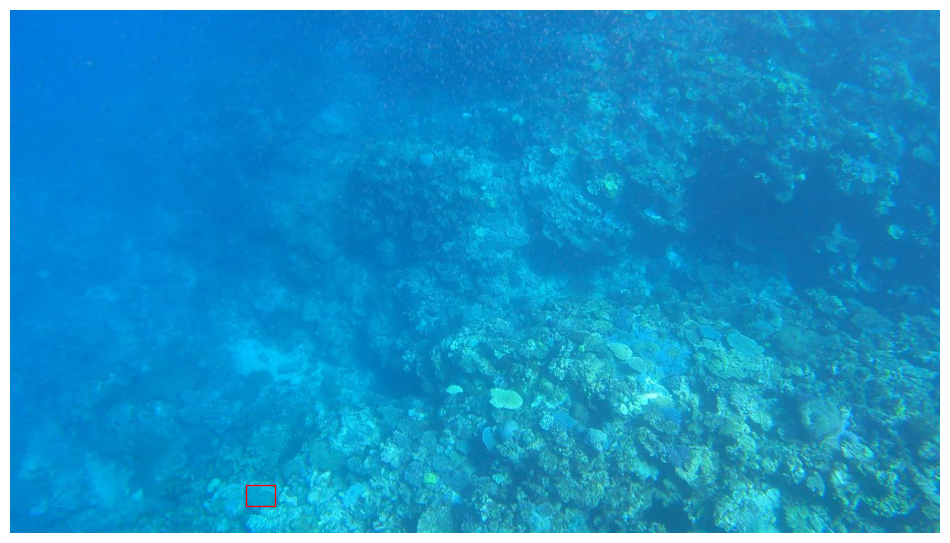

bbox: [[344.0, 668.5, 40.0, 29.000000000000004]]
normalized bbox: [[0.26875, 0.9284722222222223, 0.03125, 0.04027777777777778]]


In [26]:
import random

IMAGE_PATH = DATASET_PATH + 'train/images'

train_images = os.listdir(IMAGE_PATH)

random_image = random.choice(train_images)
# print(random_image)
image_path = os.path.join(IMAGE_PATH, random_image)
label_path = image_path.replace("images", "labels").replace(".jpg", ".txt")
print(f"image path: {image_path}")

display_image_path_with_label_path(image_path, label_path)

print(f"bbox: {label_path_to_bbox(label_path, normalized=False)}")
print(f"normalized bbox: {label_path_to_bbox(label_path)}")

In [16]:
def xywh_to_xyxy(xywh_bboxes):
    """
    Convert bounding box from (x, y, width, height) to (x_min, y_min, x_max, y_max).

    Args:
        xywh (list or tuple): Bounding box in (x, y, width, height) format.

    Returns:
        list: Bounding box in (x_min, y_min, x_max, y_max) format.
    """
    xyxy_bboxes = []
    for xywh in xywh_bboxes:
        x, y, w, h = xywh
        x_min = x
        y_min = y
        x_max = x + w
        y_max = y + h
        xyxy_bboxes.append([x_min, y_min, x_max, y_max])
    return xyxy_bboxes

    


def xyxy_to_xywh(xyxy_bboxes):
    """
    Convert bounding box from (x_min, y_min, x_max, y_max) to (x, y, width, height).

    Args:
        xyxy (list or tuple): Bounding box in (x_min, y_min, x_max, y_max) format.

    Returns:
        list: Bounding box in (x, y, width, height) format.
    """
    xywh_bboxes = []
    for xyxy in xyxy_bboxes:
        x_min, y_min, x_max, y_max = xyxy
        x = x_min
        y = y_min
        width = x_max - x_min
        height = y_max - y_min
        xywh_bboxes.append([x, y, width, height])
    return xywh_bboxes

In [15]:
import torch
import torchvision.transforms as transforms
import kornia
import matplotlib.pyplot as plt
from PIL import Image

# Define Kornia augmentations
augmentation_pipeline = kornia.augmentation.AugmentationSequential(
    kornia.augmentation.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.9),
#     data_keys=["input"]
)

In [ ]:
# display random image after augmentation

# Load the image
train_images = os.listdir(IMAGE_PATH)

random_image = random.choice(train_images)
# print(random_image)
image_path = os.path.join(IMAGE_PATH, random_image)
label_path = image_path.replace("images", "labels").replace(".jpg", ".txt")
print(label_path)
image = Image.open(image_path)

# Convert the image to a tensor
transform = transforms.ToTensor()
image_tensor = transform(image)

# Example bounding boxes in the format (xmin, ymin, xmax, ymax)
bboxes = label_path_to_bbox(label_path, normalized=False)
# print(f"bbox xywh before aug: {bboxes}")
# xyxy_bboxes = xywh_to_xyxy(bboxes)
# xywh_bboxes_tensor = torch.tensor(bboxes, dtype=torch.float32)

# Add batch dimension
image_tensor = image_tensor.unsqueeze(0)

# Apply the augmentations to the image and bounding boxes
# augmented_image_tensor = augmentation_pipeline(image_tensor, xywh_bboxes_tensor)
augmented_image_tensor = augmentation_pipeline(image_tensor)

# Remove batch dimension for visualization
augmented_image_tensor = augmented_image_tensor.squeeze(0)

# Convert the tensor to a PIL image
augmented_image = transforms.ToPILImage()(augmented_image_tensor)
# augmented_bboxes = augmented_bboxes.tolist()

# Display the original and augmented images with bounding boxes
print(f"bbox before aug: {bboxes}")
print("image before aug:")
plot_image_with_bboxes(image, bboxes, normalized=False)

# print(f"bbox after aug: {augmented_bboxes}")
# plot_image_with_bboxes(augmented_image, augmented_bboxes, normalized=False)
plot_image_with_bboxes(augmented_image, bboxes, normalized=False)

In [16]:
!mkdir {DATASET_PATH}/train_aug
!mkdir {DATASET_PATH}/train_aug/images
!mkdir {DATASET_PATH}/train_aug/labels

In [42]:
from datetime import datetime
# Define paths
AUG_IMAGE_PATH = IMAGE_PATH.replace("train", "train_aug")

# List of all images in the directory
train_images = os.listdir(IMAGE_PATH)

# Define the transformation
transform = transforms.ToTensor()

start = datetime.now()
# Process images and labels
[(
    transforms.ToPILImage()(
        augmentation_pipeline(
            transform(
                Image.open(os.path.join(IMAGE_PATH, rel_image_path))
            ).unsqueeze(0)
        ).squeeze(0)
    ).save(os.path.join(AUG_IMAGE_PATH, rel_image_path)),
    
    shutil.copy(
        os.path.join(IMAGE_PATH, rel_image_path).replace("images", "labels").replace(".jpg", ".txt"),
        os.path.join(AUG_IMAGE_PATH, rel_image_path).replace("images", "labels").replace(".jpg", ".txt")
    )
) for rel_image_path in train_images]

end = datetime.now()

print(f"time took for aug images with list comprehnesion: {end-start}")

time took for aug images with list comprehnesion: 0:14:42.672430


In [ ]:
# create augmented trained images directory
# Load the image
train_images = os.listdir(IMAGE_PATH)

AUG_IMAGE_PATH = IMAGE_PATH.replace("train", "train_aug")

start = datetime.now()

for rel_image_path in train_images:
    image_path = os.path.join(IMAGE_PATH, rel_image_path)
    label_path = image_path.replace("images", "labels").replace(".jpg", ".txt")
    image = Image.open(image_path)

    # Convert the image to a tensor
    transform = transforms.ToTensor()
    image_tensor = transform(image)

    # Example bounding boxes in the format (xmin, ymin, xmax, ymax)
    # bboxes = label_path_to_bbox(label_path, normalized=False)
    # print(f"bbox xywh before aug: {bboxes}")
    # xyxy_bboxes = xywh_to_xyxy(bboxes)
    # xywh_bboxes_tensor = torch.tensor(bboxes, dtype=torch.float32)

    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)

    # Apply the augmentations to the image and bounding boxes
#     augmented_image_tensor, augmented_bboxes = augmentation_pipeline(image_tensor, xywh_bboxes_tensor)
    augmented_image_tensor = augmentation_pipeline(image_tensor)
    # Remove batch dimension for visualization
    augmented_image_tensor = augmented_image_tensor.squeeze(0)

    # Convert the tensor to a PIL image
    augmented_image = transforms.ToPILImage()(augmented_image_tensor)
    # augmented_bboxes = augmented_bboxes.tolist()
    aug_image_path = os.path.join(AUG_IMAGE_PATH, rel_image_path) 
    aug_label_path = aug_image_path.replace("images", "labels").replace(".jpg", ".txt")
    
    augmented_image.save(aug_image_path)
    shutil.copy(label_path, aug_label_path)

end = datetime.now()
print(f"time took for aug images with loop: {end-start}")

In [27]:
!cat datasets/COTSKaggle-1/data.yaml

names:
- starfish
nc: 1
roboflow:
    license: CC BY 4.0
    project: cotskaggle
    url: https://universe.roboflow.com/david-glu/cotskaggle/dataset/1
    version: 1
    workspace: david-glu
test: /kaggle/working/datasets/COTSKaggle-1/test/images
train: /kaggle/working/datasets/COTSKaggle-1/train/images
val: /kaggle/working/datasets/COTSKaggle-1/valid/images


In [28]:
os.environ['WANDB_DISABLED'] = 'true'

In [14]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.7
    Uninstalling widgetsnbextension-3.6.7:
      Successfully uninstalled widgetsnbextension-3.6.7
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [30]:
model = YOLOv10(f'{HOME}/weights/yolov10n.pt')
results = model.train(
data=DATASET_PATH + 'data.yaml',
epochs=5,
imgsz=640,
batch=32,
lr0=0.01,
momentum=0.9,
weight_decay=0.0005,
degrees=30.0,
optimizer='AdamW',
patience=10,
augment=True,
hsv_h = 0.9999, # image HSV-Hue augmentation (fraction)
hsv_s = 0.7, # image HSV-Saturation augmentation (fraction)
hsv_v = 0.4, # image HSV-Value augmentation (fraction)
)

New https://pypi.org/project/ultralytics/8.2.72 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/weights/yolov10n.pt, data=/kaggle/working/datasets/COTSKaggle-1/data.yaml, epochs=5, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, 

2024-08-04 17:40:55.248070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 17:40:55.248198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 17:40:55.371906: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 130MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/COTSKaggle-1/train/labels... 6972 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6972/6972 [00:05<00:00, 1287.86it/s]


train: New cache created: /kaggle/working/datasets/COTSKaggle-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/datasets/COTSKaggle-1/valid/labels... 1474 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1474/1474 [00:01<00:00, 1242.28it/s]


val: New cache created: /kaggle/working/datasets/COTSKaggle-1/valid/labels.cache
Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train4
Starting training for 5 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


        1/5      5.68G      2.863      3.777      1.568      2.744      4.205      1.378        152        640: 100%|██████████| 218/218 [01:39<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.67it/s]


                   all       1474       3541    0.00214    0.00621   0.000678   0.000242

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


        2/5      5.66G      2.522      3.198      1.418      2.546       3.69      1.284         76        640: 100%|██████████| 218/218 [01:35<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.26it/s]


                   all       1474       3541     0.0885       0.05     0.0185    0.00643

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


        3/5      5.86G       2.37      2.916      1.353      2.439      3.469      1.246        115        640: 100%|██████████| 218/218 [01:33<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]


                   all       1474       3541      0.164      0.106     0.0549     0.0207

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


        4/5      5.79G      2.247      2.723      1.301      2.335      3.301      1.214        115        640: 100%|██████████| 218/218 [01:32<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.15it/s]


                   all       1474       3541      0.323      0.165      0.144      0.063

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


        5/5      5.78G      2.177       2.57      1.275      2.282      3.171      1.199        144        640: 100%|██████████| 218/218 [01:32<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.24it/s]


                   all       1474       3541      0.436       0.21      0.199     0.0658

5 epochs completed in 0.156 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 5.7MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:11<00:00,  2.09it/s]


                   all       1474       3541      0.371      0.208      0.168     0.0542
Speed: 0.1ms preprocess, 4.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/train4


lr/pg0,█▅▁▁▁
lr/pg1,▁▆█▃▃
lr/pg2,▁▆█▃▃
metrics/mAP50(B),▁▂▃▇█
metrics/mAP50-95(B),▁▂▃█▇
metrics/precision(B),▁▃▄▇█
metrics/recall(B),▁▃▄▇█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_om,█▅▃▂▁


In [ ]:
!yolo task=detect mode=train epochs=10 batch=32 plots=True \
model={HOME}/weights/yolov10n.pt \
data=datasets/COTSKaggle-1/data.yaml 

In [31]:
!pip install supervision

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 4.8 MB/s eta 0:00:00


In [33]:
# from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/runs/detect/train4/weights/best.pt')
train_images = os.listdir(IMAGE_PATH)

random_image = random.choice(train_images)
# print(random_image)
image_path = os.path.join(IMAGE_PATH, random_image)
label_path = image_path.replace("images", "labels").replace(".jpg", ".txt")

image = Image.open(image_path)

results = model(source=image_path, conf=0.25)[0]


image 1/1 /kaggle/working/datasets/COTSKaggle-1/train/images/0-9914_jpg.rf.4788fb87d36c8c794004277fd4fd7570.jpg: 384x640 (no detections), 68.9ms
Speed: 2.4ms preprocess, 68.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


original image:
[[0.597265625, 0.43472222222222223, 0.02734375, 0.05555555555555555]]


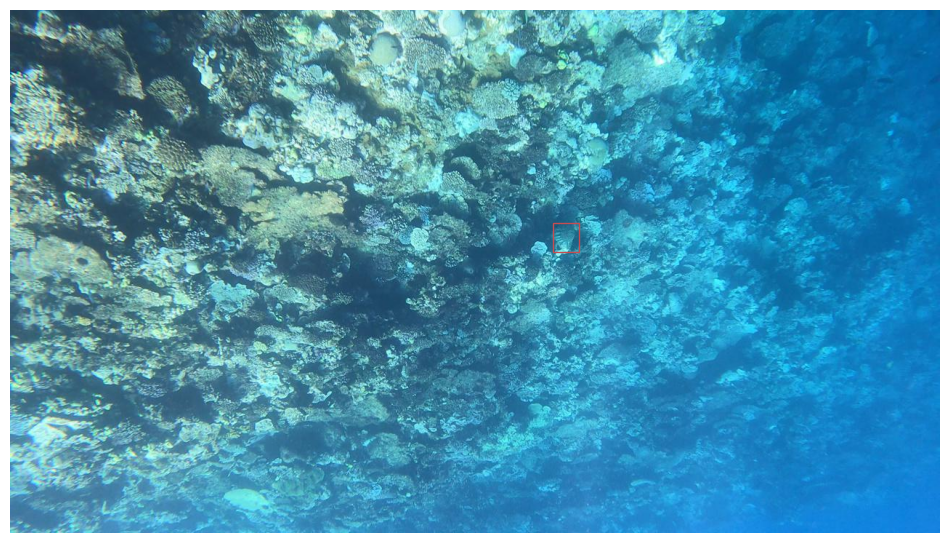

predicted result:
[]


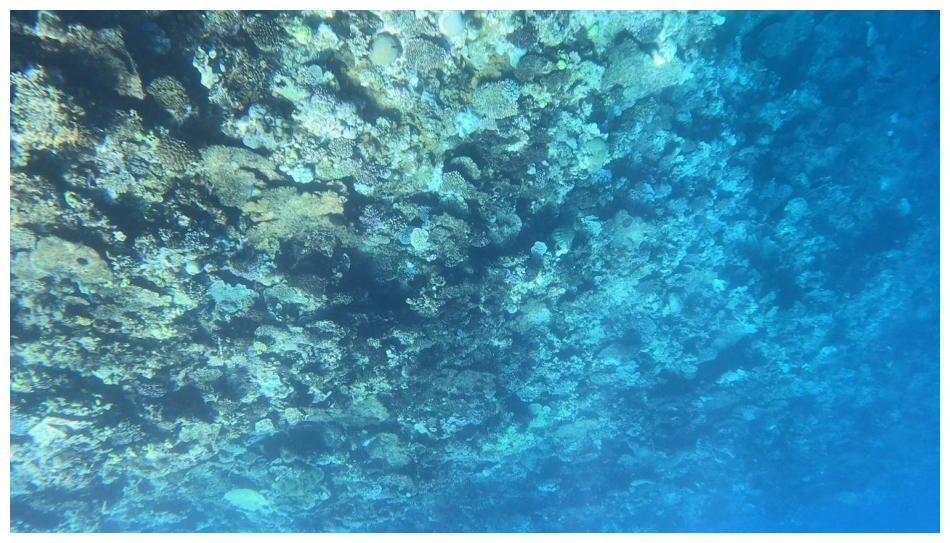

In [34]:
import supervision as sv

detections = sv.Detections.from_ultralytics(results)
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=image, detections=detections)

print("original image:")
bboxes = label_path_to_bbox(label_path, normalized=True)
print(bboxes)
display_image_path_with_label_path(image_path, label_path)


print("predicted result:")
predicted_bboxes = results.boxes.xywhn.tolist()
print(predicted_bboxes)
sv.plot_image(annotated_image)

In [35]:
with open(DATASET_PATH + 'data.yaml', 'r') as f:
    data = yaml.safe_load(f)

# data['names'] = ['starfish']
# data['train'] = DATASET_PATH + 'train/images'
data['val'] = DATASET_PATH + 'test/images'
# data['test'] = DATASET_PATH +'test/images'

with open(DATASET_PATH + 'data.yaml', 'w') as file:
    yaml.dump(data, file, indent=4)

In [36]:
!cat {DATASET_PATH}/'data.yaml'

names:
- starfish
nc: 1
roboflow:
    license: CC BY 4.0
    project: cotskaggle
    url: https://universe.roboflow.com/david-glu/cotskaggle/dataset/1
    version: 1
    workspace: david-glu
test: /kaggle/working/datasets/COTSKaggle-1/test/images
train: /kaggle/working/datasets/COTSKaggle-1/train/images
val: /kaggle/working/datasets/COTSKaggle-1/test/images


In [38]:
# Run validation on a set specified as 'val' argument
metrics = model.val(data=DATASET_PATH + 'data.yaml')

Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/working/datasets/COTSKaggle-1/test/labels... 983 images, 1 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<00:00, 1308.07it/s]

val: New cache created: /kaggle/working/datasets/COTSKaggle-1/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:07<00:00,  8.48it/s]


                   all        983       2237      0.352      0.192      0.168      0.057
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val2


In [39]:
metrics.results_dict

{'metrics/precision(B)': 0.35204554846837705,
 'metrics/recall(B)': 0.19177469825659366,
 'metrics/mAP50(B)': 0.16755090256230706,
 'metrics/mAP50-95(B)': 0.05703631351257776,
 'fitness': 0.0680877724175507}